In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import umap.umap_ as umap
from tqdm import tqdm
from math import ceil
import seaborn as sns
import copy
import random
import math
from collections import Counter
from sklearn.decomposition import PCA

%matplotlib inline

In [44]:
K = 32
MALIGNANT_PER_PSEUDOPATIENT = 35

In [4]:
memberships = pd.read_csv("../../data/GBM_Neftel/CanSig_MetaMembership.csv", index_col=0)
memberships = memberships[memberships["metamembership"] != "-2.0"]
memberships.index = ["-".join(x.split("-")[:-1]) for x in memberships.index.tolist()]

In [5]:
metadata = pd.read_csv("../../data/GBM_Neftel/Metadata.txt", skiprows=[1], index_col=0, delimiter="\t")

In [6]:
dataset = pd.read_csv("../../data/GBM_Neftel/IDHwtGBM.processed.SS2.logTPM.txt", index_col=0, delimiter="\t")

In [7]:
change_scale = np.vectorize(lambda y: np.power(2,y)-1)

In [8]:
malignant_states = [f"metasig{i}" for i in range(1,6)]
tme_states = ["Macrophage", "Oligodendrocyte", "T-cell"]

In [9]:
def get_purity(data, mapping):
    cnt_malignant, cnt_tme = 0, 0
    for k in mapping:
        if k in malignant_states:
            cnt_malignant += mapping[k].size
        else:
            assert k in tme_states
            cnt_tme += mapping[k].size
    return 1.0 * cnt_malignant / (cnt_malignant + cnt_tme), cnt_malignant, cnt_tme

In [10]:
def get_cells(mapping, cell_types):
    cells = pd.Index([])
    for k in mapping:
        if k in cell_types:
            cells = cells.union(mapping[k])
    return cells

In [11]:
def get_gexp_prop(pseudopatient, mapping):
    new_mapping = copy.deepcopy(mapping)
    for cell_type in mapping:
        # new mapping because we resampled cells
        new_mapping[cell_type] = new_mapping[cell_type].intersection(pseudopatient.columns)
    
    gexp_ = pseudopatient.agg(np.mean, axis=1)
    true_prop_ = pd.Series(name="true_proportions", dtype='float64')
    for cell_type in new_mapping:
        true_prop_[cell_type] = get_cells(new_mapping, [cell_type]).size
    true_prop_ = true_prop_.div(true_prop_.sum())
    return gexp_, true_prop_
    

In [12]:
# TODO better sampling
def sample_cells(cells, mapping, counts):
    if len(cells)==0: return [[] for count in counts]
    batches = math.ceil(sum(counts)/len(cells))
    sampled = cells.copy()
    sampled *= batches
    random.shuffle(sampled)
    #print("sampled",sampled,"at ratio",sum(counts)/len(cells))

    i = 0
    arr = []
    for count in counts:
        arr.append(sampled[i:i+count])
        i += count
    return arr
    return [random.sample(cells, count) for count in counts]

In [13]:
def lo_tme_ct(prop):
    cts = pd.Index(tme_states).intersection(prop.index)
    if len(cts) == 1:
        # only one tme type -> cant leave anything out
        return False
        
    # count celltypes that have value 0 in prop -> tme type present but not sampled
    # print(prop[cts], (prop[cts]==0).any())
    return (prop[cts]==0).sum() >= 1

In [14]:
def frac_to_cnt(cell_cnt, fracs):
    cells_per_partition = fracs.apply(lambda frac: math.floor(cell_cnt*frac))
    diff_per_partition = fracs.apply(lambda frac: cell_cnt*frac-math.floor(cell_cnt*frac))
    remaining_cells = cell_cnt - sum(cells_per_partition)
    diff_per_partition = diff_per_partition.sort_values(ascending=False)
    for i in range(remaining_cells):
        partition_index = diff_per_partition.index[i]
        cells_per_partition[partition_index] += 1
    return cells_per_partition

In [15]:
x = pd.read_csv(f"../../data/GBM_Neftel/signatures/estimate_tme_markers.csv", index_col=0)
x.drop("V2", axis=1, inplace=True)
tme_genes = pd.Index(x.values.flatten()).intersection(dataset.index)

In [16]:
dataset.loc[~dataset.index.isin(tme_genes)]

,MGH101-P1-A04,MGH101-P1-A05,MGH101-P1-A07,MGH101-P1-A09,MGH101-P1-A10,MGH101-P1-A11,MGH101-P1-B03,MGH101-P1-B04,MGH101-P1-B06,MGH101-P1-B09,...,MGH66-P08-G07,MGH66-P08-G10,MGH66-P08-G11,MGH66-P08-H01,MGH66-P08-H02,MGH66-P08-H06,MGH66-P08-H07,MGH66-P08-H08,MGH66-P08-H10,MGH66-P08-H11
GENE,,,,,,,,,,,,,,,,,,,,,
A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.157691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.096262,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.841269,0.000000,0.000000,0.000000,0.000000,0.000000,0.782409
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.012926,0.000000,0.000000,0.022900,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,0.000000,5.327184,0.000000,8.698337,8.205094,7.355166,5.968506,8.976143,5.786100,2.589524,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M-AS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.126973,0.645241,0.625738,0.319618,0.280956,0.344828,0.172488,0.137504,0.250962,0.474047,...,0.000000,0.311503,0.000000,0.284514,0.564622,0.000000,0.000000,0.000000,0.793272,0.237564
ZYG11B,0.310340,0.230203,0.345964,0.467801,0.190299,0.000000,0.221568,0.144046,0.219091,0.325386,...,0.561693,3.457332,1.541019,0.102994,0.000000,0.000000,0.286881,2.295723,0.000000,3.066261
ZYX,0.000000,0.000000,0.000000,0.000000,0.000000,2.009347,4.768237,0.531069,0.000000,0.000000,...,3.365273,2.905928,5.040410,4.307647,1.887135,6.324973,4.558696,3.503476,0.000000,4.451936


In [17]:
def bulkify_malignant(MALIGNANT_PER_PSEUDOPATIENT=MALIGNANT_PER_PSEUDOPATIENT):
    tuples = [(patient, i) for patient in metadata["Sample"].unique() for i in range(K)]
    index = pd.MultiIndex.from_tuples(tuples, names=["patient", "pseudopatient"])
    gexp = pd.DataFrame(index=index, columns=dataset.index.difference(tme_genes))
    true_prop = pd.DataFrame(index=index, columns=(malignant_states+tme_states))
    gexp_orig = pd.DataFrame(index=metadata["Sample"].unique(), columns=dataset.index.difference(tme_genes))
    true_prop_orig = pd.DataFrame(index=metadata["Sample"].unique(), columns=(malignant_states+tme_states))

    cnt_lo_tme = Counter() # % of times we left out >= 1 tme celltype when sampling

    for sample_name, metadata_sample in metadata.groupby("Sample"):
        i = 0
        barcodes = metadata_sample.index
        dataset_sample = dataset[barcodes]
        dataset_sample = dataset_sample.loc[~dataset_sample.index.isin(tme_genes)]
        dataset_sample = dataset_sample.apply(change_scale)

        cell_mapping = {}
        malignant_cells = []
        tme_cells = []
        malignant_cts = 0

        for cell_type, metadata_cell_type in metadata_sample.groupby("CellAssignment"):
            cell_index = metadata_cell_type.index
            if cell_type == "Malignant":
                # only take those malignant cells malignant state is known
                cell_index = cell_index.intersection(memberships.index)
                for malignant_state, malignant_state__cells in memberships.loc[cell_index].groupby("metamembership"):
                    malignant_cts += 1
                    cell_mapping[malignant_state] = malignant_state__cells.index
                    malignant_cells += malignant_state__cells.index.tolist()
            else:
                cell_mapping[cell_type] = cell_index
                tme_cells += cell_index.tolist()

        # prefiltering
        dataset_sample = dataset_sample[get_cells(cell_mapping, malignant_states + tme_states)]
        purity, M, T = get_purity(dataset_sample, cell_mapping)  
        print(f"sample {sample_name}: it has purity {purity*100}% and {M=}, {T=}")
        if purity < .1:
            print(f"sample {sample_name} discarded")
            continue

        # original patient    
        true_prop_ = pd.Series(name="true_proportions", dtype='float64')
        for cell_type in cell_mapping:
            true_prop_[cell_type] = get_cells(cell_mapping, [cell_type]).size
        true_prop_ = true_prop_.div(true_prop_.sum())
        gexp_orig.loc[sample_name] = dataset_sample.agg(np.mean, axis=1)
        true_prop_orig.loc[sample_name] = true_prop_


        # take 1 patient which has many malignant cells;
        # take all malignant cells it has, shuffle them,
        # split them withouht replacement to generate i.e. 4 patients out of them,
        # decide how much purity you want to have for each patient (should be between 40 - 99 %)
        # and draw as many TME cells as needed to get this purity. So answering your question - yes,
        # best would be to have also different ranges of purity for samples 

        malignant_partitions = None#np.array_split(malignant_cells, cnt_pseudopatients)
        cnt_pseudopatients = round(len(malignant_cells)/MALIGNANT_PER_PSEUDOPATIENT)

        assert cnt_pseudopatients <= K

        metasignature_proba = pd.DataFrame()
        malignant_partitions = [[] for _ in range(cnt_pseudopatients)]
        for ct in cell_mapping:
            if ct.startswith("metasig"):
                metasignature_proba[ct] = np.random.dirichlet(np.ones_like(np.arange(cnt_pseudopatients)))
                metasignature_proba[ct] = frac_to_cnt(len(cell_mapping[ct]), metasignature_proba[ct])
                #print(ct,len(cell_mapping[ct]))
                cells_todraw = cell_mapping[ct].tolist()
                random.shuffle(cells_todraw)

                for j in range(cnt_pseudopatients):
                    # draw metasignature_proba.loc[j,ct] many cells of ct for pseudopatient j
                    N = metasignature_proba.loc[j,ct]
                    #print(f"{N} cells of {ct} for pseudopatient {j}")
                    malignant_partitions[j] += cells_todraw[:N]
                    cells_todraw = cells_todraw[N:]
                assert cells_todraw == []

        #display(metasignature_proba)
        #print(malignant_partitions)    

        M_ = len(malignant_partitions[0])
        min_purity = max(M_ / (M_ + T), 0.4)
        max_purity = max(0.99, min_purity)
        # choose purities
        sample_purities = np.linspace(min_purity, max_purity, len(malignant_partitions))

        tme_cnts = []
        for desired_purity in sample_purities:
            #desired_purity = random.uniform(min_purity, max_purity)
            T_ = M_*(1-desired_purity)/desired_purity
            #print(f"split has purity {min_purity} if taking all tme cells, we desire purity {desired_purity}, we need {T_} TME cells")
            tme_cnts.append(round(T_))

        # sample TME cells
        # TODO leave out cell type with certain chance if we can
        sampled_tme = sample_cells(tme_cells, cell_mapping, tme_cnts)

        # build the pseudopatients
        for malignant_split, tme_partition in zip(malignant_partitions, sampled_tme):
            dataset_pseudopatient = dataset_sample[list(malignant_split) + tme_partition]
            #print(malignant_split)
            x = {}
            for cl in malignant_split:
                for ct in cell_mapping:
                    if cl in cell_mapping[ct]:
                        try:
                            x[ct] += 1
                        except:
                            x[ct] = 0
            #print(x)

            #display(dataset_pseudopatient)
            gexp_, true_prop_ = get_gexp_prop(dataset_pseudopatient, cell_mapping)
            gexp.loc[(sample_name, i)] = gexp_
            true_prop.loc[(sample_name, i)] = true_prop_
            cnt_lo_tme[lo_tme_ct(true_prop_)] += 1
            i += 1
    return gexp, true_prop, gexp_orig, true_prop_orig

In [45]:
gexp, true_prop, gexp_orig, true_prop_orig = bulkify_malignant()

sample BT1160: it has purity 100.0% and M=141, T=0
sample BT1187: it has purity 0.0% and M=0, T=211
sample BT1187 discarded
sample BT749: it has purity 98.48484848484848% and M=130, T=2
sample BT771: it has purity 85.52631578947368% and M=65, T=11
sample BT786: it has purity 95.77464788732394% and M=68, T=3
sample BT830: it has purity 100.0% and M=86, T=0
sample BT85: it has purity 98.83720930232558% and M=85, T=1
sample BT920: it has purity 92.44186046511628% and M=159, T=13
sample MGH100: it has purity 100.0% and M=143, T=0
sample MGH101: it has purity 63.84615384615384% and M=83, T=47
sample MGH102: it has purity 57.08502024291497% and M=141, T=106
sample MGH104: it has purity 100.0% and M=191, T=0
sample MGH105: it has purity 51.42857142857142% and M=252, T=238
sample MGH106: it has purity 57.333333333333336% and M=86, T=64
sample MGH110: it has purity 69.47368421052632% and M=132, T=58
sample MGH113: it has purity 67.37588652482269% and M=95, T=46
sample MGH115: it has purity 95.2

In [46]:
true_prop = true_prop.dropna(axis=0, how="all")
gexp = gexp.dropna(axis=0, how="all")
true_prop = true_prop.fillna(0.0)
gexp = gexp.fillna(0.0)

true_prop_orig = true_prop_orig.dropna(axis=0, how="all")
gexp_orig = gexp_orig.dropna(axis=0, how="all")
true_prop_orig = true_prop_orig.fillna(0.0)
gexp_orig = gexp_orig.fillna(0.0)

pur=true_prop.loc[:,true_prop.columns.str.startswith("metasig")].sum(axis=1).values

In [47]:
pca = PCA(n_components=2)
pca.fit(gexp.apply(lambda x: np.log2(x+1)))

PCA(n_components=2)

Text(0.5, 1.0, 'Pseudopatient PCA stratified by original patient')

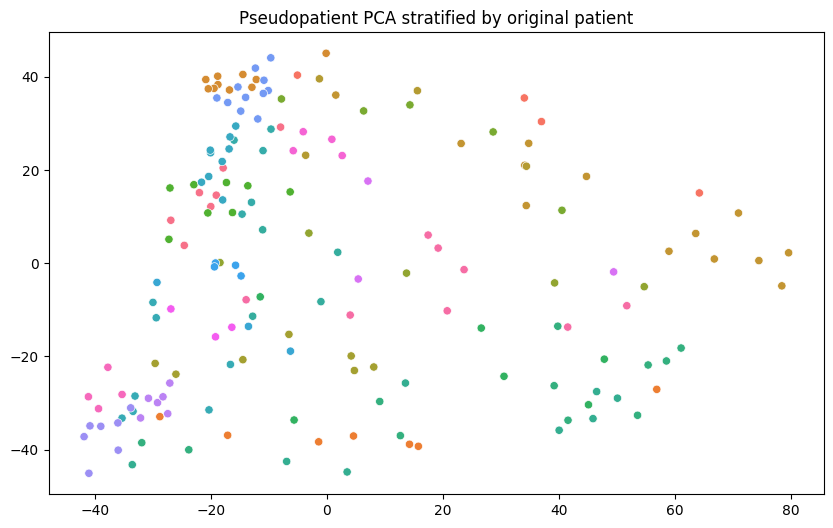

In [48]:
z = pca.transform(gexp.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
sns.scatterplot(x=pc1,y=pc2,hue=[a for (a,b) in gexp.index],legend=False)
xlim = plt.xlim()
ylim = plt.ylim()
plt.title("Pseudopatient PCA stratified by original patient")

Text(0.5, 1.0, 'PCA of original patient')

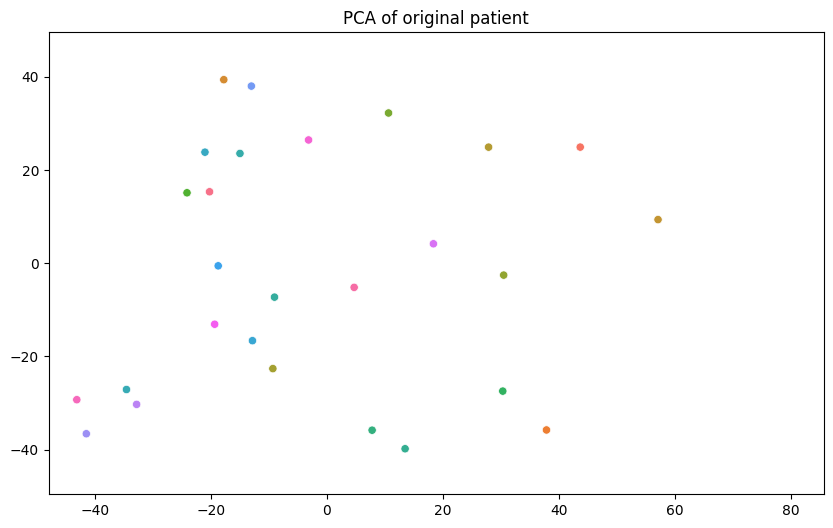

In [49]:
z = pca.transform(gexp_orig.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
plt.figure(figsize=(10,6))
plt.xlim(xlim)
plt.ylim(ylim)
sns.scatterplot(x=pc1,y=pc2,hue=gexp_orig.index.tolist(),legend=False)
plt.title("PCA of original patient")

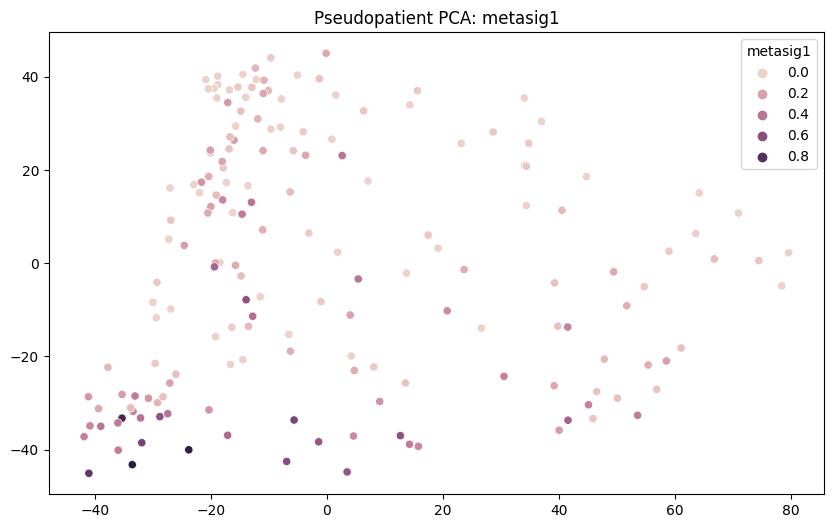

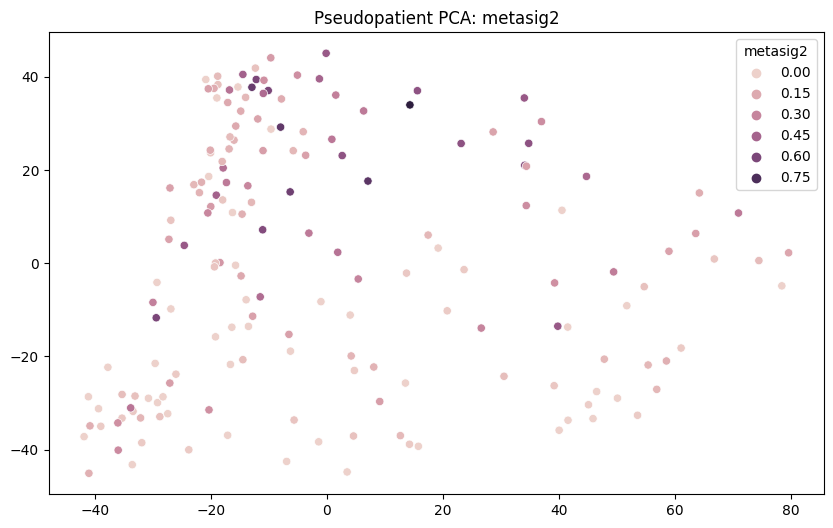

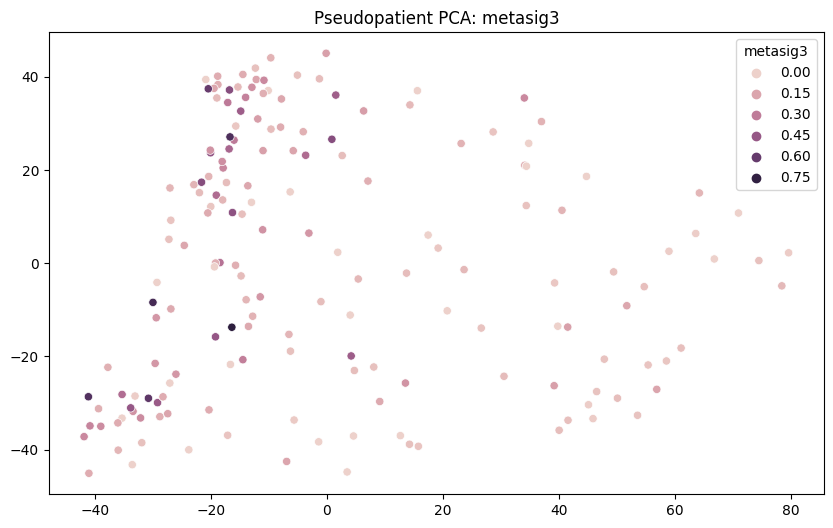

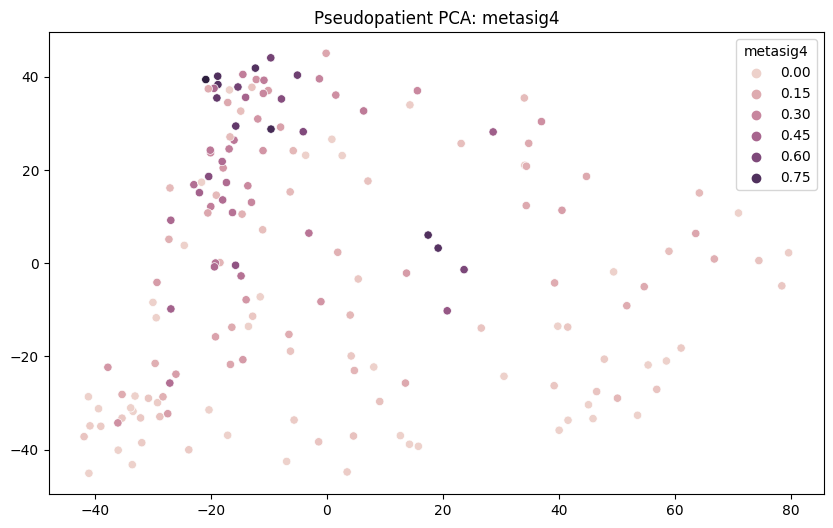

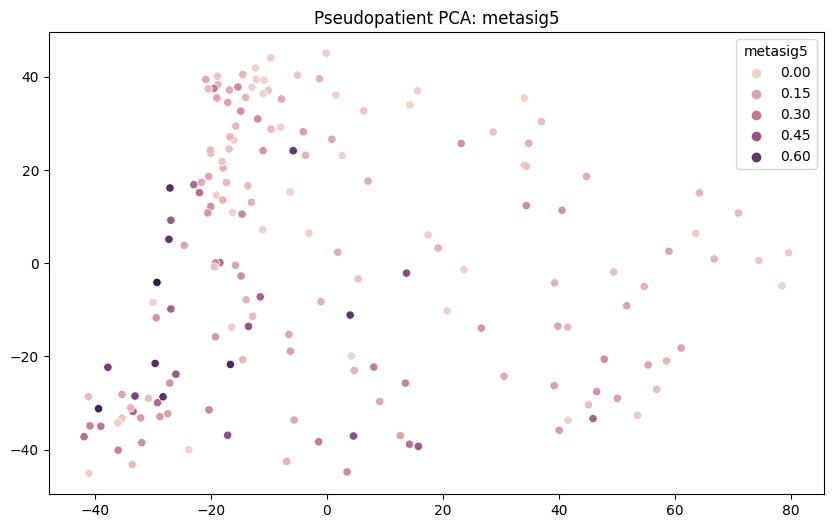

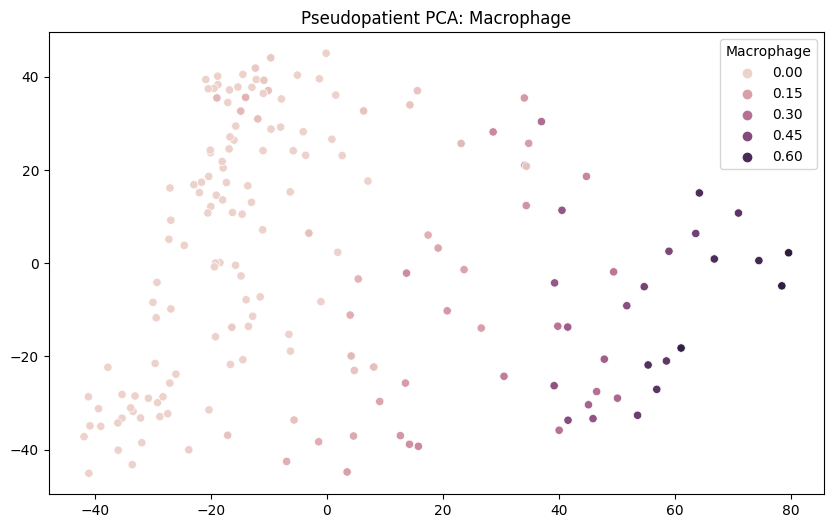

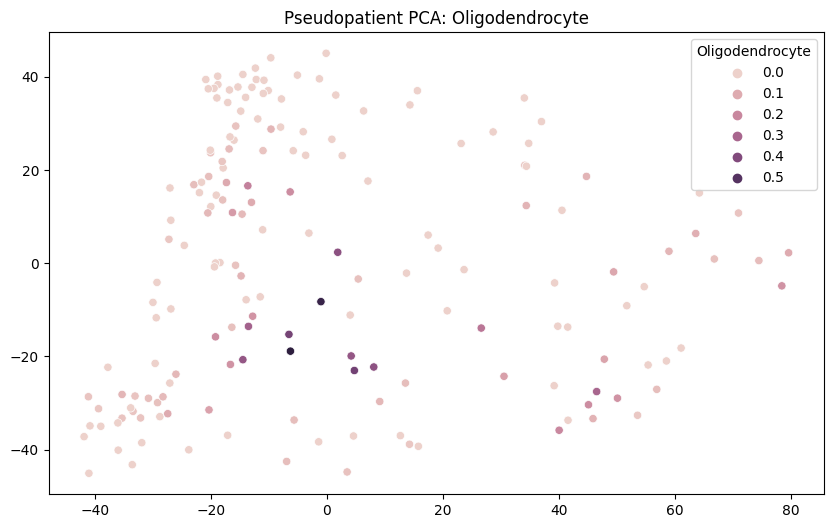

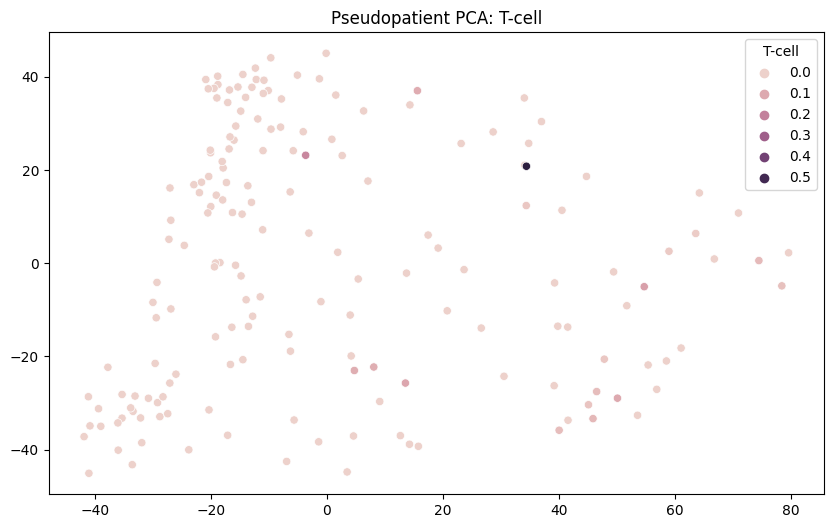

In [50]:
z = pca.transform(gexp.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)
for ct in malignant_states+tme_states:
    plt.figure(figsize=(10,6))
    plt.xlim(xlim)
    plt.ylim(ylim)
    true_prop[f"{ct}"] = true_prop[ct]
    sns.scatterplot(x=pc1,y=pc2,hue=true_prop[f"{ct}"])
    plt.title(f"Pseudopatient PCA: {ct}")
    plt.show()

In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [52]:
high_dimensional_clustering = False # set to true if cluster in gene expression space instead of pca space

In [53]:
z = pca.transform(gexp.apply(lambda x: np.log2(x+1)))
pc1, pc2 = zip(*z)

if high_dimensional_clustering:
    X = gexp.apply(lambda x: np.log2(x+1))
else:
    X = np.vstack([pc1, pc2]).T


/Users/tobiasvonarx/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tobiasvonarx/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tobiasvonarx/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/tobiasvonarx/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

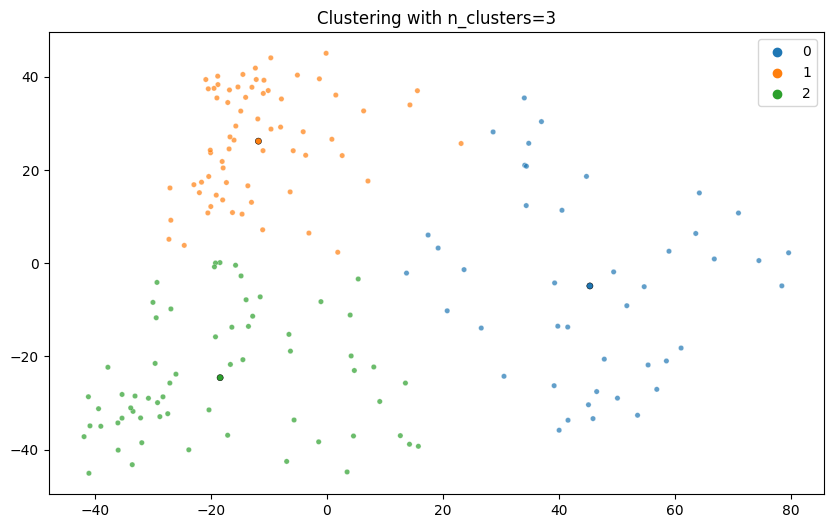

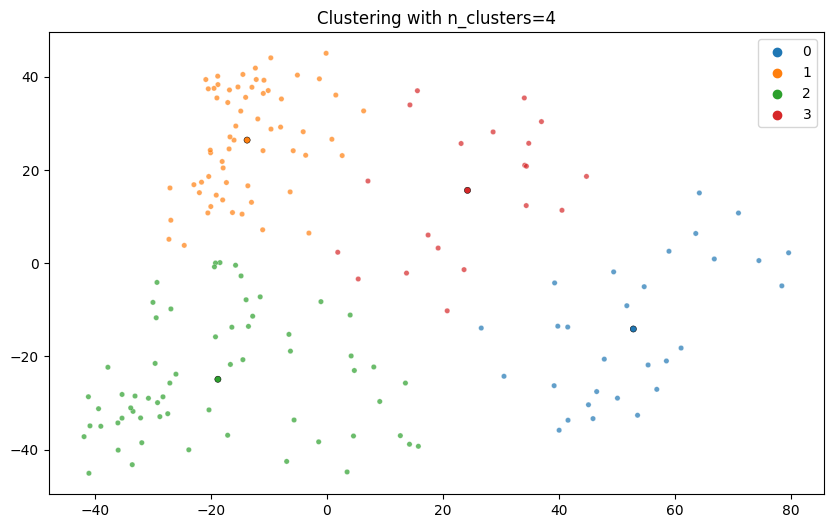

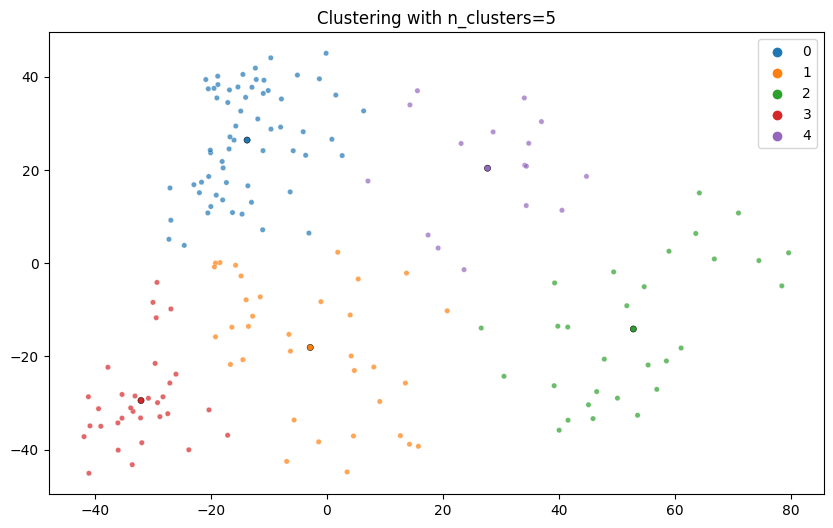

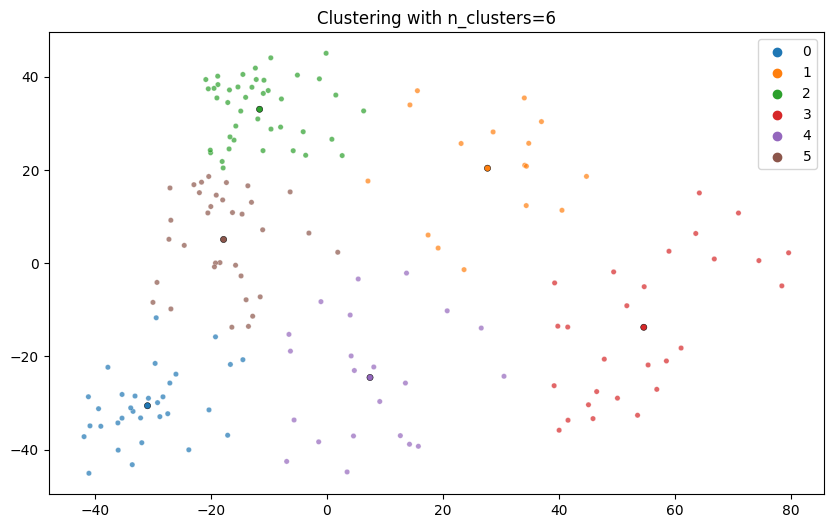

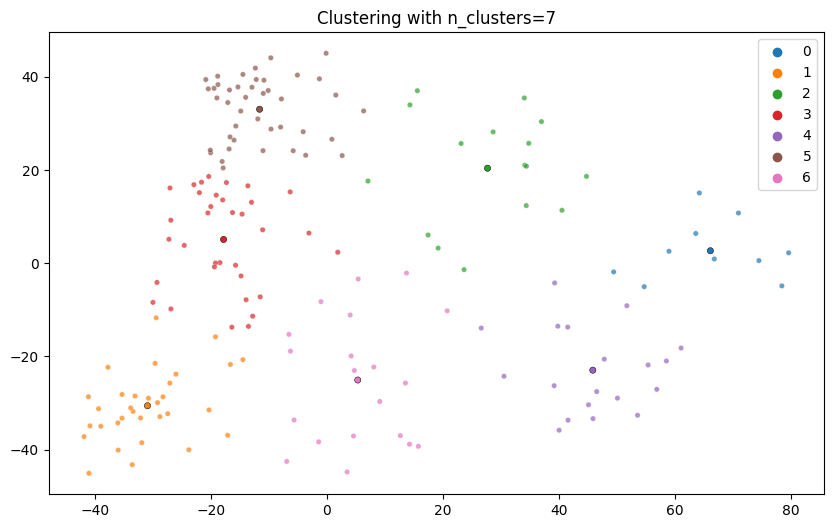

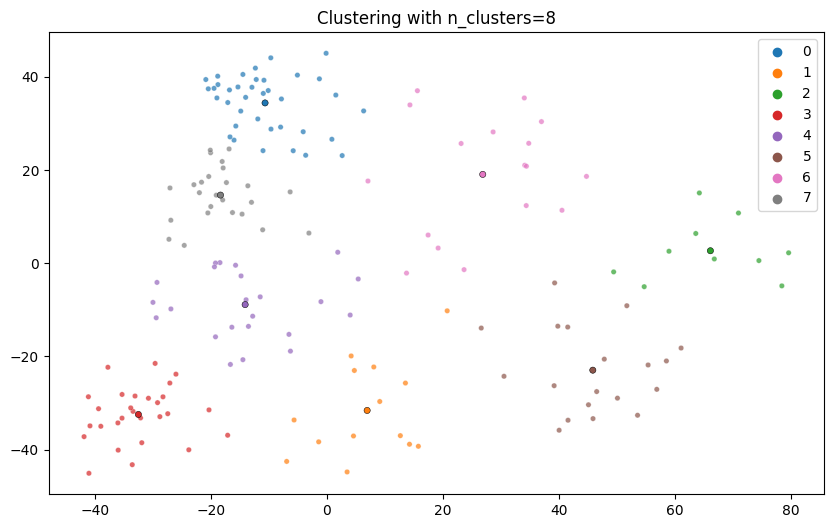

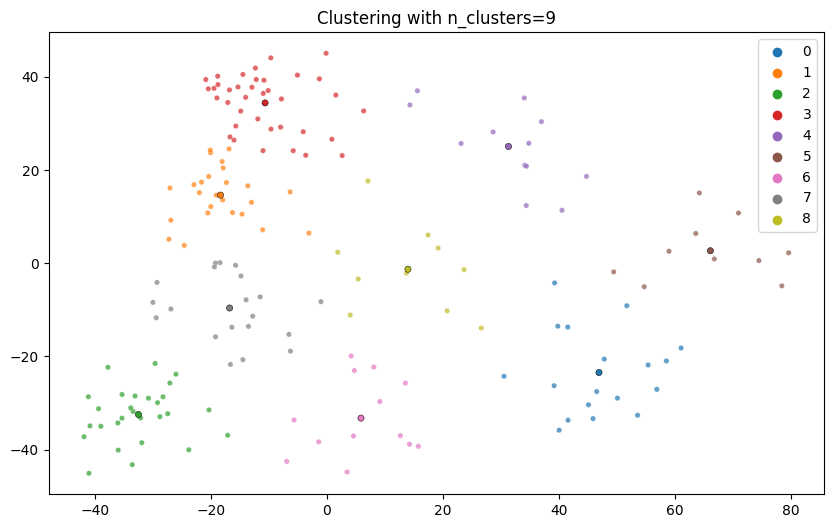

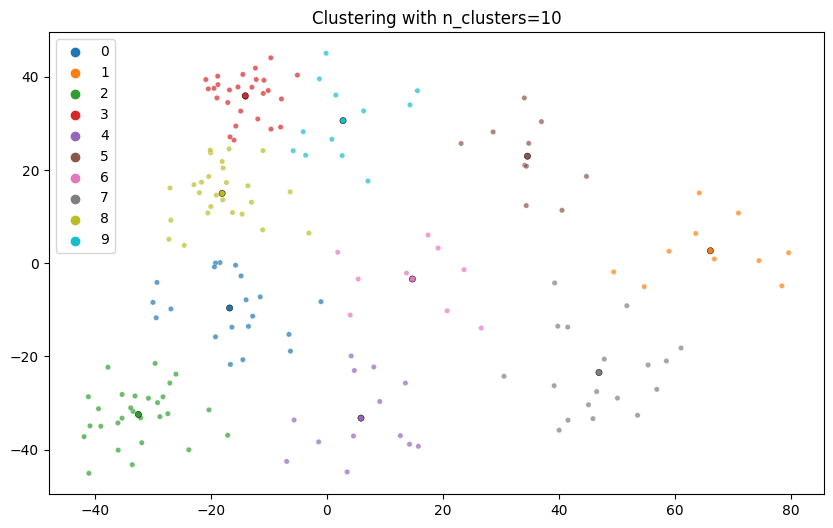

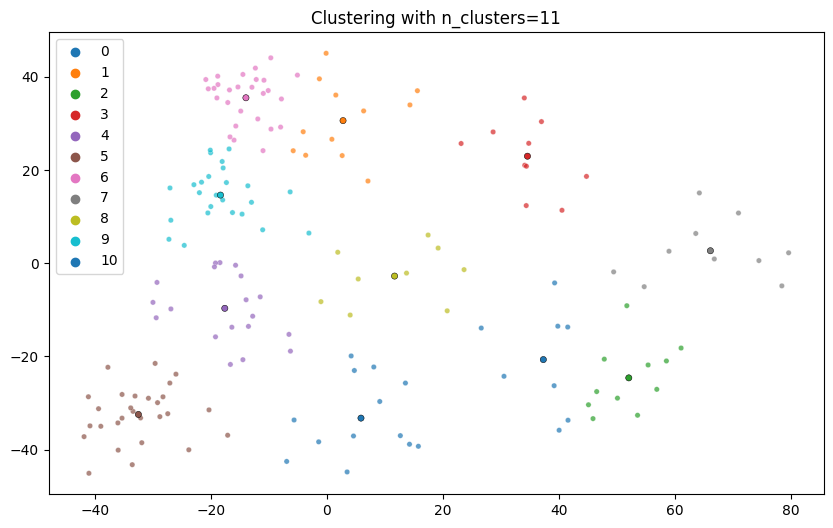

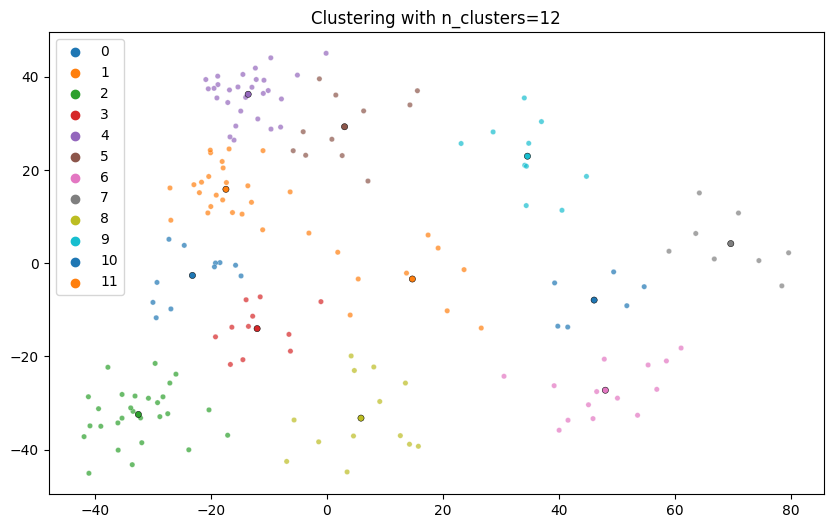

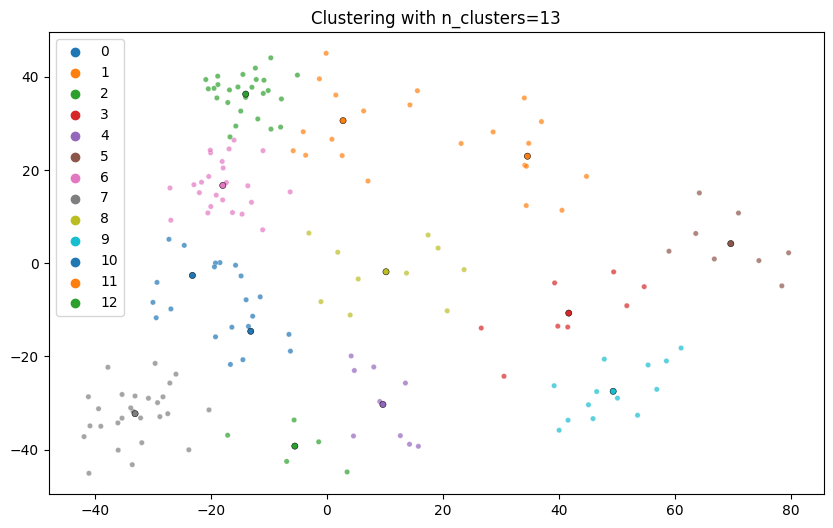

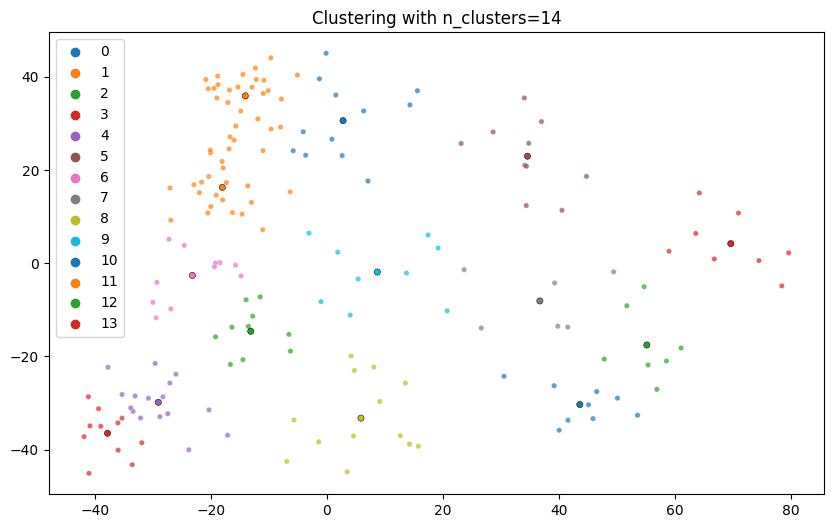

In [54]:
cluster_scores_elbow = []
cluster_scores_silhouette = []

n_clusters_range = range(3, 15)
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    labels = kmeans.predict(X)
    
    if high_dimensional_clustering:
        centers = pca.transform(kmeans.cluster_centers_)
        cc1, cc2 = zip(*centers)
    else:
        cc1, cc2 = kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]
    
    cluster_scores_silhouette.append(silhouette_score(X, labels))
    cluster_scores_elbow.append(kmeans.inertia_)

    plt.figure(figsize=(10,6))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Clustering with n_clusters={n_clusters}")
    ax = sns.scatterplot(x=pc1, y=pc2, hue=kmeans.labels_, palette="tab10", alpha=0.7, s=15)
    ax = sns.scatterplot(x=cc1, y=cc2,
                     hue=range(n_clusters), palette="tab10", s=20, ec='black', legend=False, ax=ax)

Text(0.5, 1.0, 'Elbow curve')

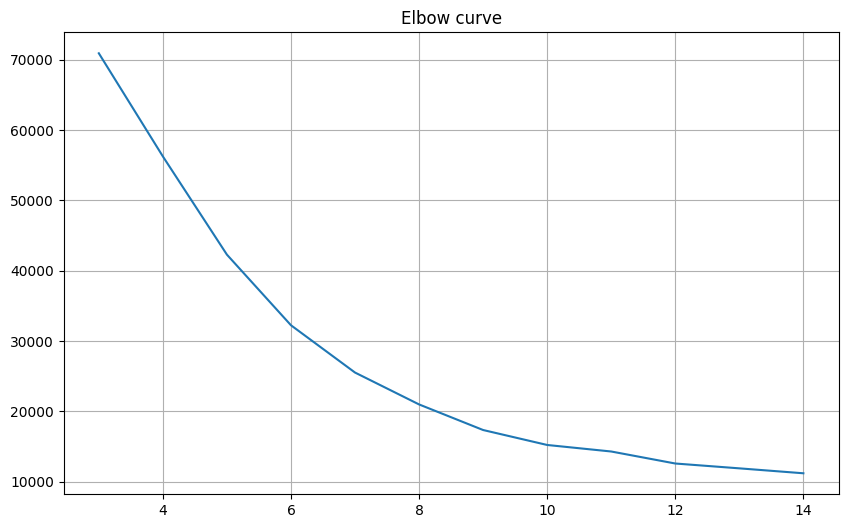

In [55]:
plt.figure(figsize=(10,6))
plt.plot(n_clusters_range, cluster_scores_elbow)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5, 1.0, 'Silhouette curve')

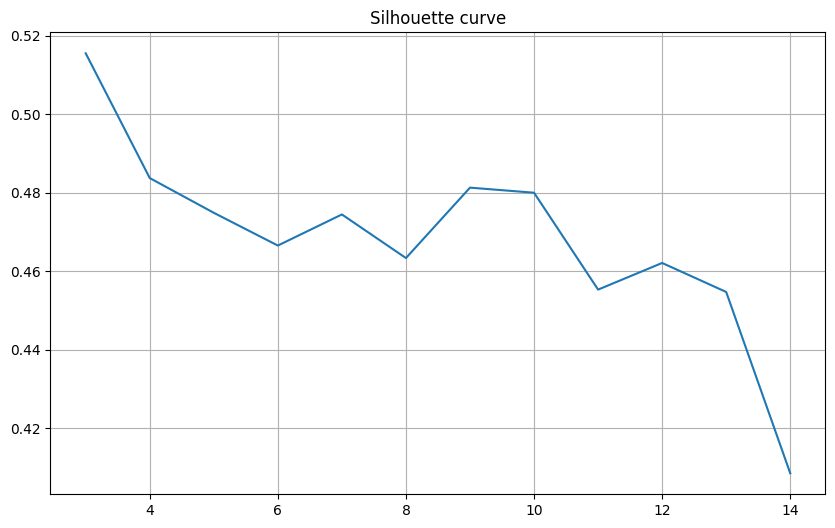

In [56]:
plt.figure(figsize=(10,6))
plt.plot(n_clusters_range, cluster_scores_silhouette)
plt.grid(True)
plt.title('Silhouette curve')